In [26]:
!pip install langchain_community langchain_groq langgraph langchain_core gradio langchain_groq

In [8]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langchain.prompts import PromptTemplate
from langchain.schema import HumanMessage
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image
from langchain_groq import ChatGroq

In [4]:
class State(TypedDict):
  text: str
  classification: str
  entities: List[str]
  summary: str

In [10]:
from getpass import getpass
groq_api_key = getpass()

··········


In [23]:
llm = ChatGroq(
    temperature = 0,
    groq_api_key = groq_api_key,
    model_name = "llama-3.3-70b-versatile"
)

In [18]:
def classification_node(state: State):
  "News, Blog, Research or Others"
  prompt = PromptTemplate(
      input_variables=["text"],
      template = "Classify the given text into one of the following categories: Research, Blog, News, or Others.\n \nText: {text}\n\nCategory:"
  )

  message = HumanMessage(content = prompt.format(text = state["text"]))
  classification = llm.invoke([message]).content.strip() # The model's response might contain unwanted leading or trailing spaces or newlines.
  return {"classification": classification}

def extract_entities(state: State):
  prompt = PromptTemplate(
      input_variables=["text"],
      template = "Extract all entities(Person, Organization, Location) from the given text and provide the result as a comma seperated list.\n \nText: {text}\n\nEntities:"
  )

  message = HumanMessage(content = prompt.format(text = state["text"]))
  entities = llm.invoke([message]).content.strip().split(", ")
  return {"entities": entities}

def summarize(state: State):
  prompt = PromptTemplate(
      input_variables=["text"],
      template = "Summarize the given text in few sentences.\n \nText: {text}\n\nSummary:"
  )
  message = HumanMessage(content = prompt.format(text = state["text"]))
  summary = llm.invoke([message]).content.strip()
  return {"summary": summary}

In [19]:
workflow = StateGraph(State)

workflow.add_node("classification_node",classification_node)
workflow.add_node("extract_entities",extract_entities)
workflow.add_node("summarize",summarize)

workflow.set_entry_point("classification_node")

workflow.add_edge("classification_node","extract_entities")
workflow.add_edge("extract_entities","summarize")
workflow.add_edge("summarize",END)

app = workflow.compile()

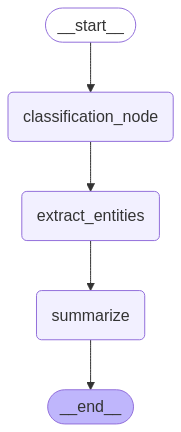

In [21]:
display(Image(
    app.get_graph().draw_mermaid_png(
        draw_method = MermaidDrawMethod.API
        )
))

In [24]:
SAMPLE_TEXT = """OpenAI has announced the GPT-4 model, which is a large multimodal model that exhibits human-level performance on various professional benchmarks. It is developed to improve the alignment and safety of AI systems.
additionally, the model is designed to be more efficient and scalable than its predecessor, GPT-3. The GPT-4 model is expected to be released in the coming months and will be available to the public for research and development purposes."""

state_input = {"text": SAMPLE_TEXT}
result = app.invoke(state_input)

In [25]:
print("Classification :", result["classification"])
print("\nEntities :", result["entities"])
print("\nSummary :", result["summary"])

Classification : Category: News. 

The text appears to be a news update about the announcement of OpenAI's GPT-4 model, its features, and its expected release. The language used is formal and objective, which is typical of news articles.

Entities : ['OpenAI', 'GPT-4', 'GPT-3']

Summary : OpenAI has announced the GPT-4 model, a large multimodal model that achieves human-level performance on various professional benchmarks. The model is designed to improve AI safety and alignment, and is more efficient and scalable than its predecessor, GPT-3. It is expected to be released soon for public research and development purposes.
